In [1]:
%matplotlib inline

import sys
import datetime
import random
import math
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

from utils import utils as ut
from utils import quandl as ql
from utils import composite
from utils import maps
from settings import TARGET_SERIES, TARGET_INDICATOR

sns.set_style("darkgrid")

PANEL_SCORE = True

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [128]:
import imp
imp.reload(ut)

<module 'utils.utils' from '/home/condauser/notebooks/utils/utils.py'>

In [129]:
tar = ql.load_target()
tar = ut.xs_winsorize(tar)
tar.ix['1996-05-31'] = np.nan
tar.ix['1996-06-30'] = np.nan
tar.ix['1998-05-31'] = np.nan
tar.ix['1998-06-30'] = np.nan

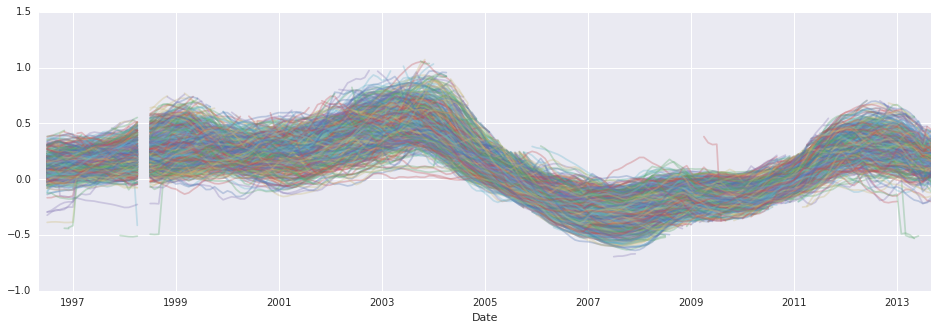

In [130]:
tar.plot(legend=False, alpha=.3, figsize=[16,5])

## increasing values

In [ ]:
series = 'IV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)

## decreasing values

In [ ]:
series = 'DV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)

## ratio sales price to list price

In [ ]:
series = 'SLPR'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)

## turnover in housing market in past year

In [ ]:
series = 'SPY'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
composite.explore_series(px, px_ca, px_us, tar)

## sold for gain

In [17]:
yoy = lambda x: x / x.shift(24) - 1.

In [18]:
series = 'SFG'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

SFG_c = px
composite.explore_series(px, px_ca, px_us, tar)

(213, 13) (189, 13)


# price per square foot

In [19]:
series = 'MVSF'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

MVSF_c = px
composite.explore_series(px, px_ca, px_us, tar)

(234, 705) (210, 705)


# momentum

In [88]:
def momentum(df, per=12):
    df = df.pct_change()
    #return pd.rolling_mean(df, window=per).dropna()
    return pd.ewma(df, halflife=per, min_periods=per).dropna(how='all')

In [89]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px, px_ca, px_us = ut.capped_transformation(momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom = px
composite.explore_series(px, px_ca, px_us, tar)

(222, 693) (222, 693)


# change in momentum

In [22]:
def momentum_change(df):
    mom_cur = momentum(df)
    mom_prev = momentum(df.shift(12))
    return (mom_cur - mom_prev).dropna(how='all')

In [23]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom_chg = px
composite.explore_series(px, px_ca, px_us, tar)

(210, 693) (210, 693)


## prep data

In [100]:
features = {}
for i in ('IV', 'DV', 'SPY'):#, 'SLPR'):
    px = ql.load_quandl_data(TARGET_INDICATOR, i)
    px = (px.fillna(method='ffill', limit=3).dropna(axis=1))
    features[i] = px
features['tar'] = tar
# features['SFG'] = SFG_c
# features['MVSF'] = MVSF_c
features['TAR_mom'] = TAR_mom
features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
df.index.levels[1].name = 'code'

In [101]:
print(df.IV.unstack().dropna(how='all').shape)
print(df.DV.unstack().dropna(how='all').shape)
print(df.SPY.unstack().dropna(how='all').shape)
#print(df.SLPR.unstack().dropna(how='all').shape)

print(df.tar.unstack().dropna(how='all').shape)

# print(df.SFG.unstack().dropna(how='all').shape)
# print(df.MVSF.unstack().dropna(how='all').shape)
print(df.TAR_mom.unstack().dropna(how='all').shape)
print(df.TAR_mom_chg.unstack().dropna(how='all').shape)

(184, 582)
(184, 582)
(184, 582)
(184, 582)
(184, 582)
(184, 582)


In [102]:
# for c in df.columns:
#     df[c] = ut.xs_winsorize(df[c].unstack()).stack()
# df.dropna(inplace=True)

In [103]:
def gen_mkt_movement(df):
    px, px_ca, px_us = ql.load_series(TARGET_SERIES)

    def expand_series_change(s, per):
        s = s.div(s.shift(per))
        return pd.DataFrame(np.repeat(np.array([s.values]).T, repeats=df.ix[:,0].unstack().shape[1], axis=1),
                            columns=df.ix[:,0].unstack().columns,
                            index=s.index)
    
    short = expand_series_change(px_ca, 6)
    med = expand_series_change(px_ca, 12)
    long = expand_series_change(px_ca, 24)
    
    mkt = ut.stack_and_align([short, med, long], cols=['short', 'med', 'long'])
    return mkt.ix[df.index]

mkt = gen_mkt_movement(df)

df = df.merge(mkt, left_index=True, right_index=True)

In [104]:
# def drop_crisis(df):
#     return (df[:datetime.datetime(2005,1,1)]
#             .append(df[datetime.datetime(2009,1,1):]))

# df = drop_crisis(df)

In [105]:
df.head()

TAR_mom_chg     SPY   TAR_mom     DV     IV       tar  \
Date       code                                                           
1998-04-30 00002     0.003300  6.2304  0.005162  19.63  74.62  0.251899   
           00007     0.006325  5.6325  0.007082  12.01  84.08  0.294183   
           00008     0.002777  6.6377  0.011093   2.06  96.93  0.436376   
           00010     0.003330  5.3848  0.009783   4.04  94.66  0.435305   
           00026     0.001276  5.3701 -0.000245  47.97  41.38  0.068927   

                     short       med      long  
Date       code                                 
1998-04-30 00002  1.033496  1.050774  1.061952  
           00007  1.033496  1.050774  1.061952  
           00008  1.033496  1.050774  1.061952  
           00010  1.033496  1.050774  1.061952  
           00026  1.033496  1.050774  1.061952

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


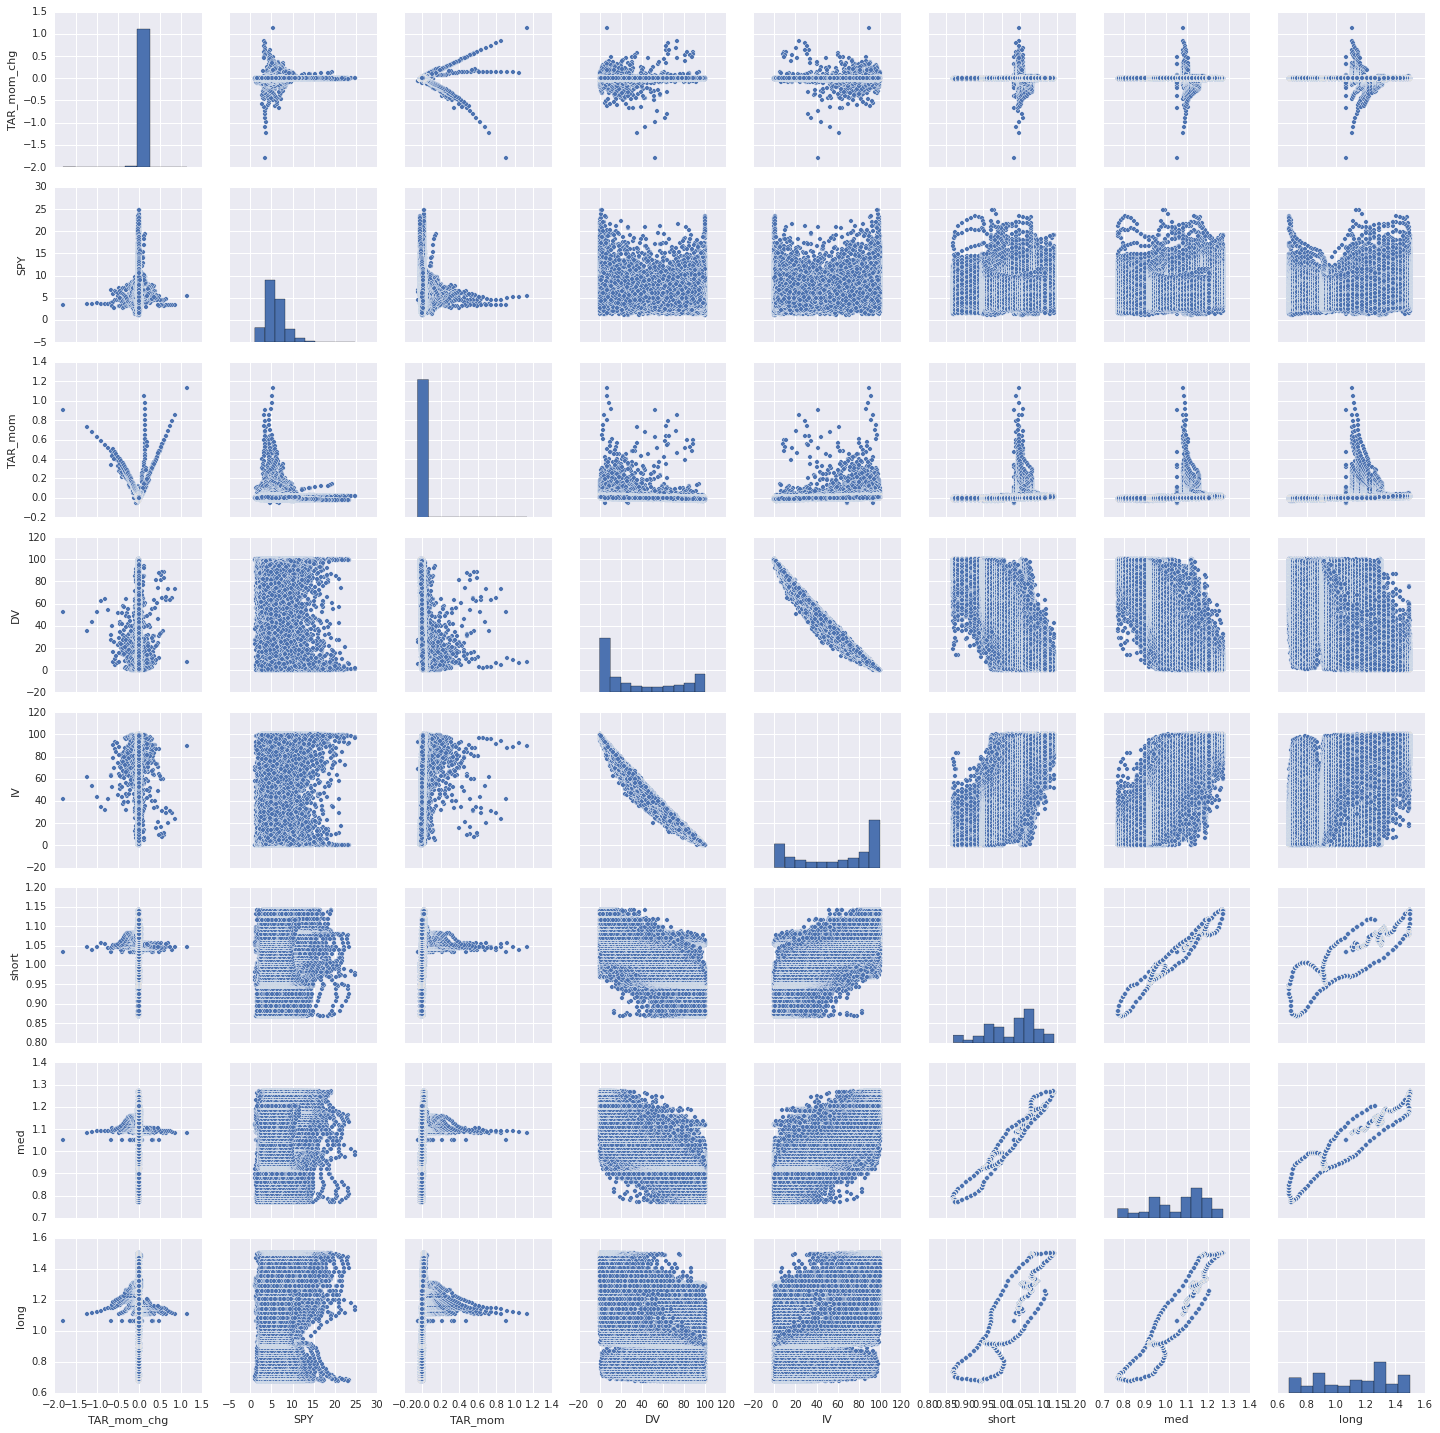

In [127]:
sns.pairplot(df[[c for c in df.columns if c != 'tar']])

In [107]:
df_ts = ut.ts_score(df, PANEL_SCORE).dropna(how='all')
df_ts.head()

TAR_mom_chg       SPY   TAR_mom        DV        IV  \
Date       code                                                         
1999-10-31 00910    -0.010981 -0.349013 -0.165784 -0.173935  0.134047   
           00919    -0.085749  6.260743 -0.146228 -0.021702  0.045334   
           00921    -0.019419  0.472554 -0.189466 -0.598082  0.514538   
           00934    -0.003428  0.884912 -0.077444 -1.211802  1.370249   
           00936    -0.043174 -0.655261 -0.245390  1.843614 -1.686391   

                       tar     short       med      long  
Date       code                                           
1999-10-31 00910  0.091617  1.394959  1.043401  1.560353  
           00919  0.075522  1.394717  1.043273  1.560037  
           00921  0.525693  1.394475  1.043144  1.559721  
           00934  0.367552  1.394233  1.043016  1.559406  
           00936 -0.460172  1.393991  1.042888  1.559091

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


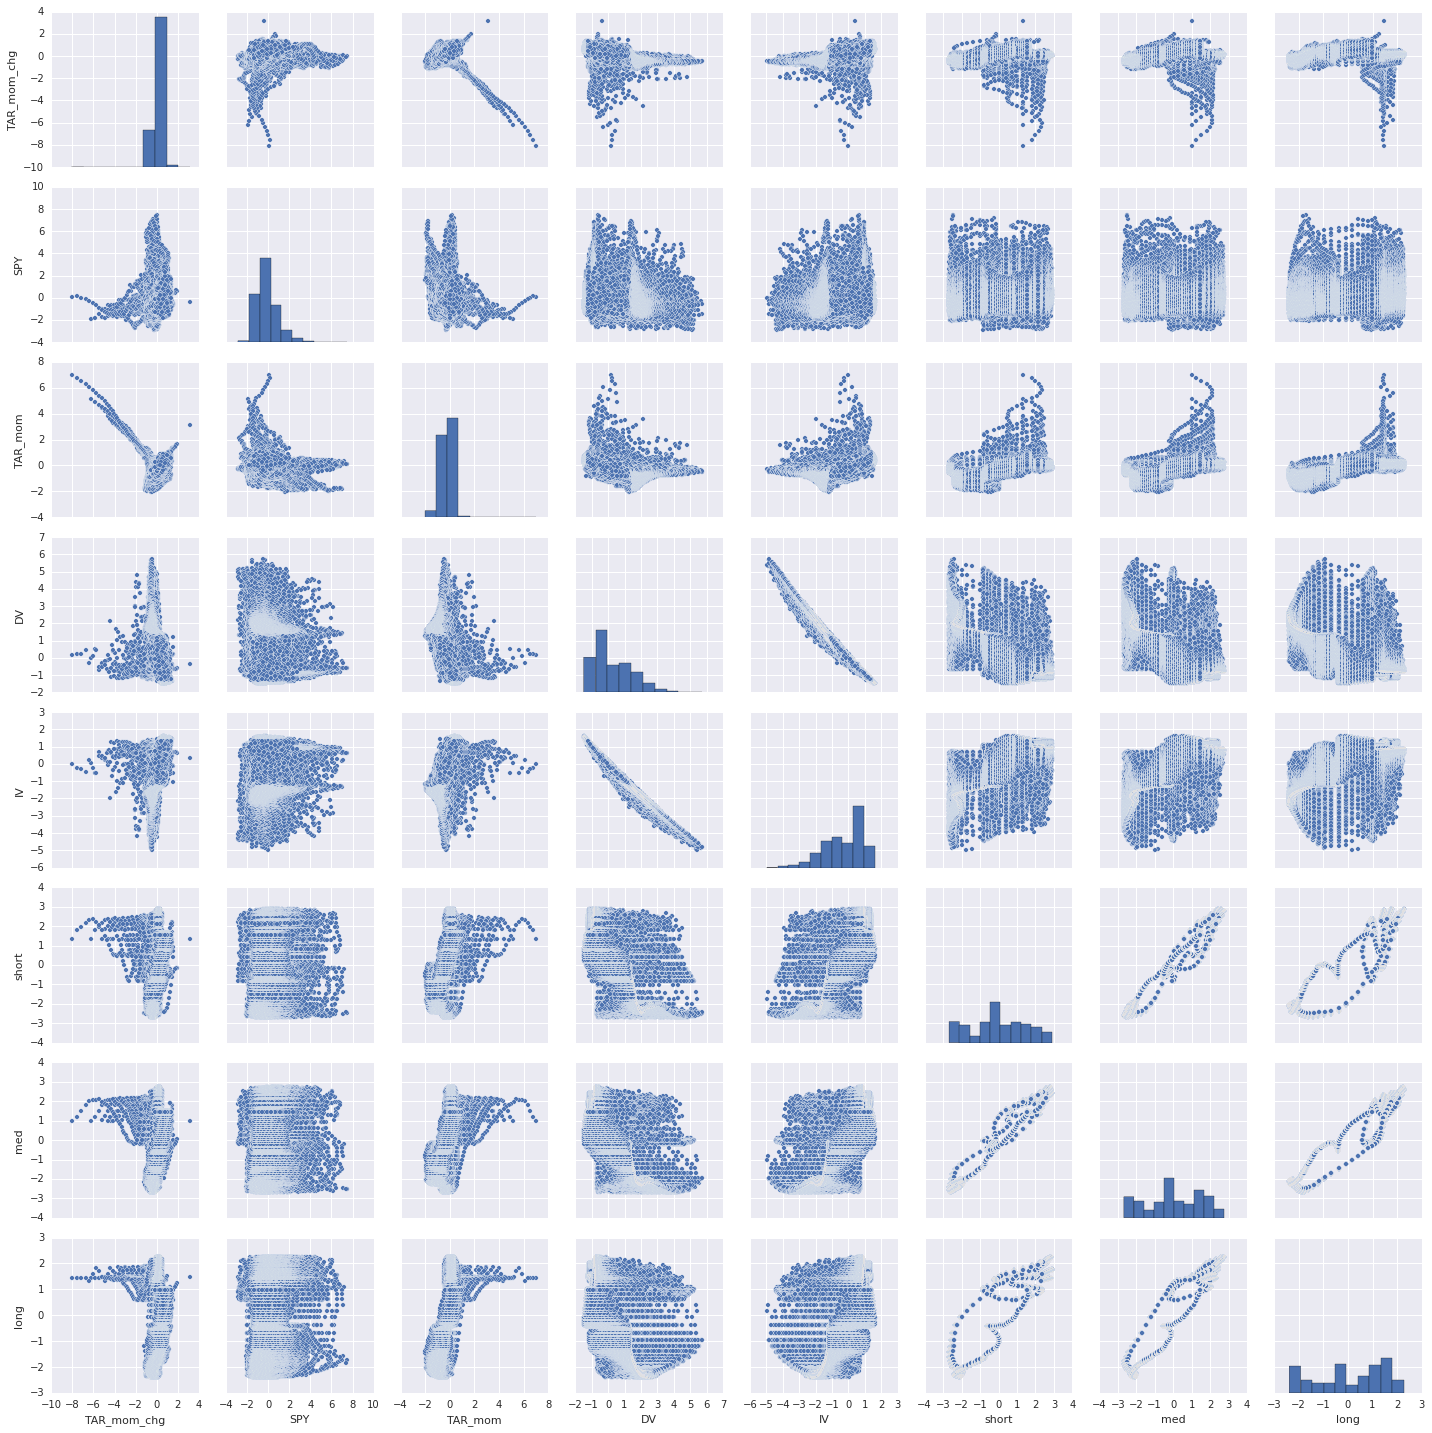

In [126]:
sns.pairplot(df_ts[[c for c in df_ts.columns if c != 'tar']])

In [109]:
print(df[df_ts.iloc[0].name[0]:df_ts.iloc[-1].name[0]].shape)
print(df_ts.shape)

(97776, 9)
(97585, 9)


## upper bound



sharpe ratios:
0.2   -0.365503
0.4    1.063617
0.6    1.918638
0.8    2.719987
1.0    3.814921
mkt    1.924826
dtype: float64


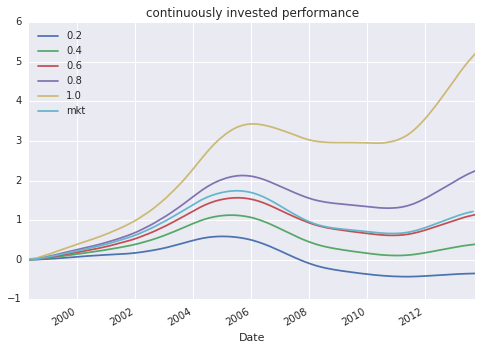

In [110]:
ret = ql.load_returns().stack().ix[df.index]    
df_res = ut.stack_and_align([df['tar'], ret], cols=('pred', 'ret'))
q = ut.gen_quintile_ts(df_res, 'pred', 'ret', agg='mean')
q['mkt'] = ql.load_returns('states').ix[:,0]
print('\n')
print('sharpe ratios:')
print(ut.get_sharpe_ratio(q))
ut.get_cum_perforance(q).plot(title='continuously invested performance')



sharpe ratios:
0.2   -0.517905
0.4    0.878574
0.6    1.711862
0.8    2.467634
1.0    3.523832
mkt    1.689440
dtype: float64


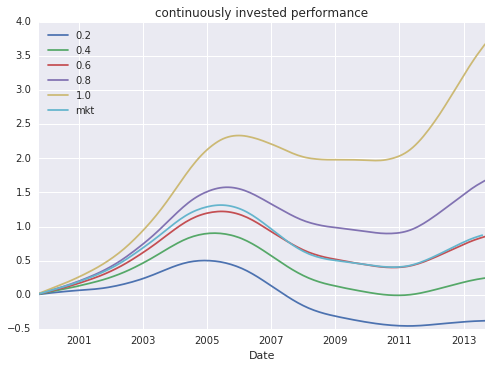

In [111]:
ret = ql.load_returns().stack().ix[df_ts.index]    
df_res = ut.stack_and_align([df_ts['tar'], ret], cols=('pred', 'ret'))
q = ut.gen_quintile_ts(df_res, 'pred', 'ret', agg='mean')
q['mkt'] = ql.load_returns('states').ix[:,0]
print('\n')
print('sharpe ratios:')
print(ut.get_sharpe_ratio(q))
ut.get_cum_perforance(q).plot(title='continuously invested performance')

##fit models

In [112]:
import imp
imp.reload(composite)
imp.reload(ut)

<module 'utils.utils' from '/home/condauser/notebooks/utils/utils.py'>

straw man (vanilla regression)

r2: 0.367133	xs corr: 0.267689


sharpe ratios:
0.2    0.897624
0.4    1.485123
0.6    1.833839
0.8    2.031907
1.0    2.137409
mkt    1.689440
dtype: float64


int: -0.258292	coef: [ 0.51839761 -0.04580804 -0.29073751 -0.18259715 -0.06257183  0.48676635
 -0.10190007 -0.13932363]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


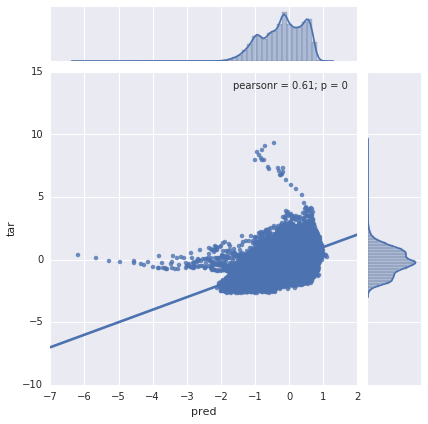

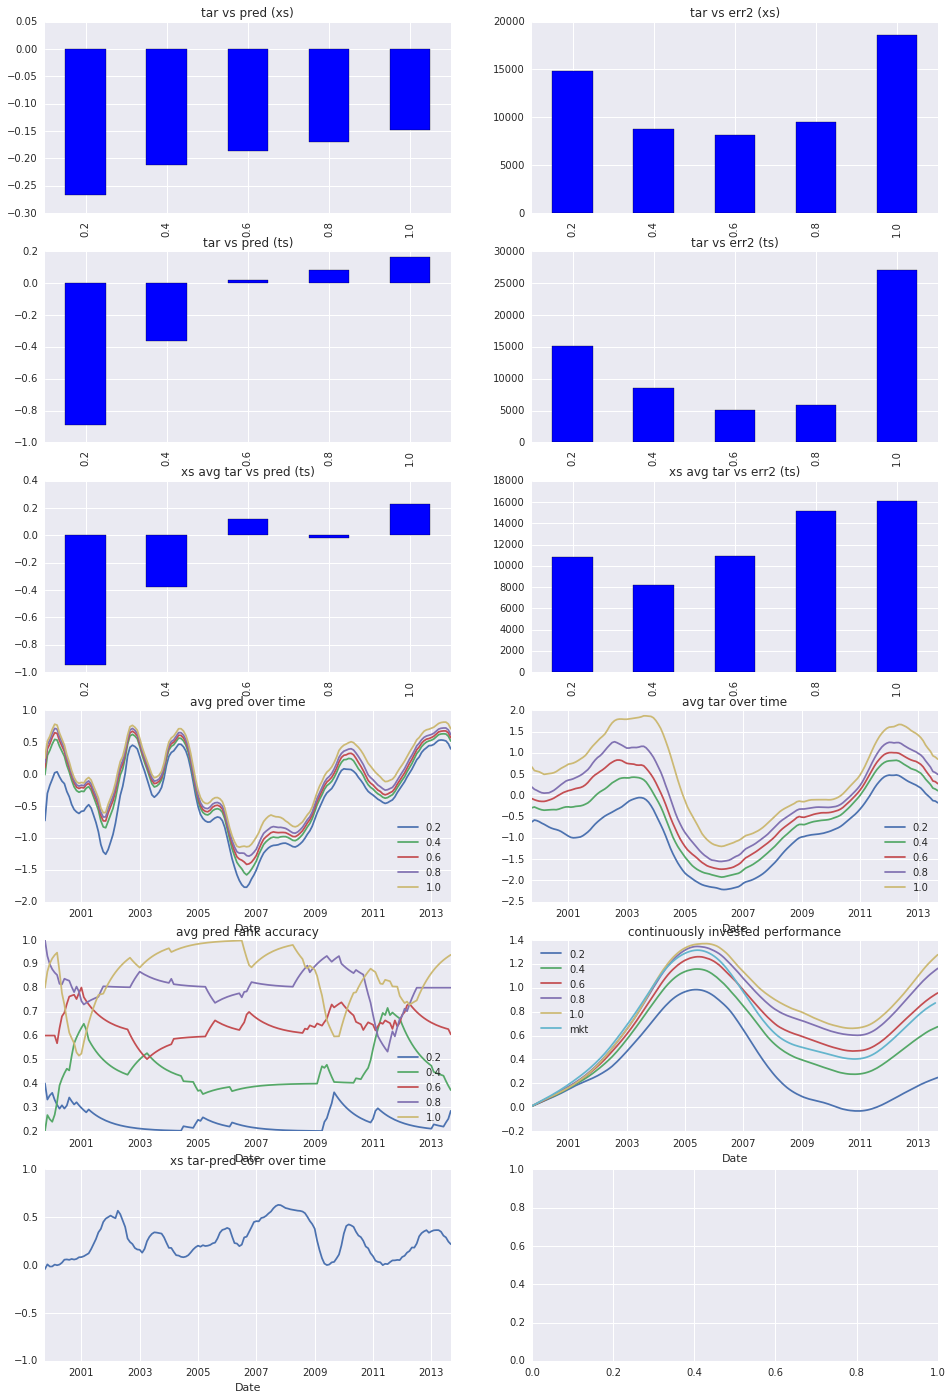

In [113]:
clf = lm.LinearRegression()
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')
res = composite.model_empirics(clf, df_ts, pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.intercept_, clf.coef_)) 

In [114]:
a_range = res[0].iloc[0].name[0], res[0].iloc[-1].name[0]
a_index = res[0].index

1999-10-31 00:00:00	2002-09-30 00:00:00	2002-10-31 00:00:00	2003-03-31 00:00:00
1999-10-31 00:00:00	2003-03-31 00:00:00	2003-04-30 00:00:00	2003-09-30 00:00:00
1999-10-31 00:00:00	2003-09-30 00:00:00	2003-10-31 00:00:00	2004-03-31 00:00:00
1999-10-31 00:00:00	2004-03-31 00:00:00	2004-04-30 00:00:00	2004-09-30 00:00:00
1999-10-31 00:00:00	2004-09-30 00:00:00	2004-10-31 00:00:00	2005-03-31 00:00:00
1999-10-31 00:00:00	2005-03-31 00:00:00	2005-04-30 00:00:00	2005-08-31 00:00:00
1999-10-31 00:00:00	2005-08-31 00:00:00	2005-09-30 00:00:00	2006-02-28 00:00:00
1999-10-31 00:00:00	2006-02-28 00:00:00	2006-03-31 00:00:00	2006-08-31 00:00:00
1999-10-31 00:00:00	2006-08-31 00:00:00	2006-09-30 00:00:00	2007-02-28 00:00:00
1999-10-31 00:00:00	2007-02-28 00:00:00	2007-03-31 00:00:00	2007-08-31 00:00:00
1999-10-31 00:00:00	2007-08-31 00:00:00	2007-09-30 00:00:00	2008-02-29 00:00:00
1999-10-31 00:00:00	2008-02-29 00:00:00	2008-03-31 00:00:00	2008-08-31 00:00:00
1999-10-31 00:00:00	2008-08-31 00:00:00	

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


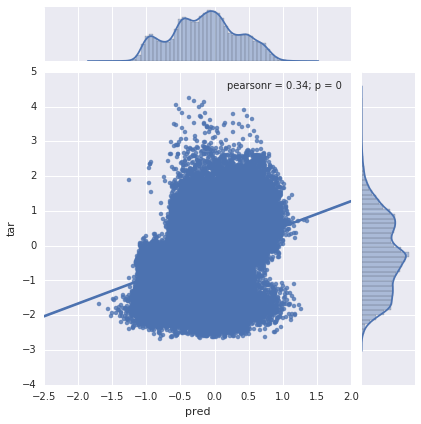

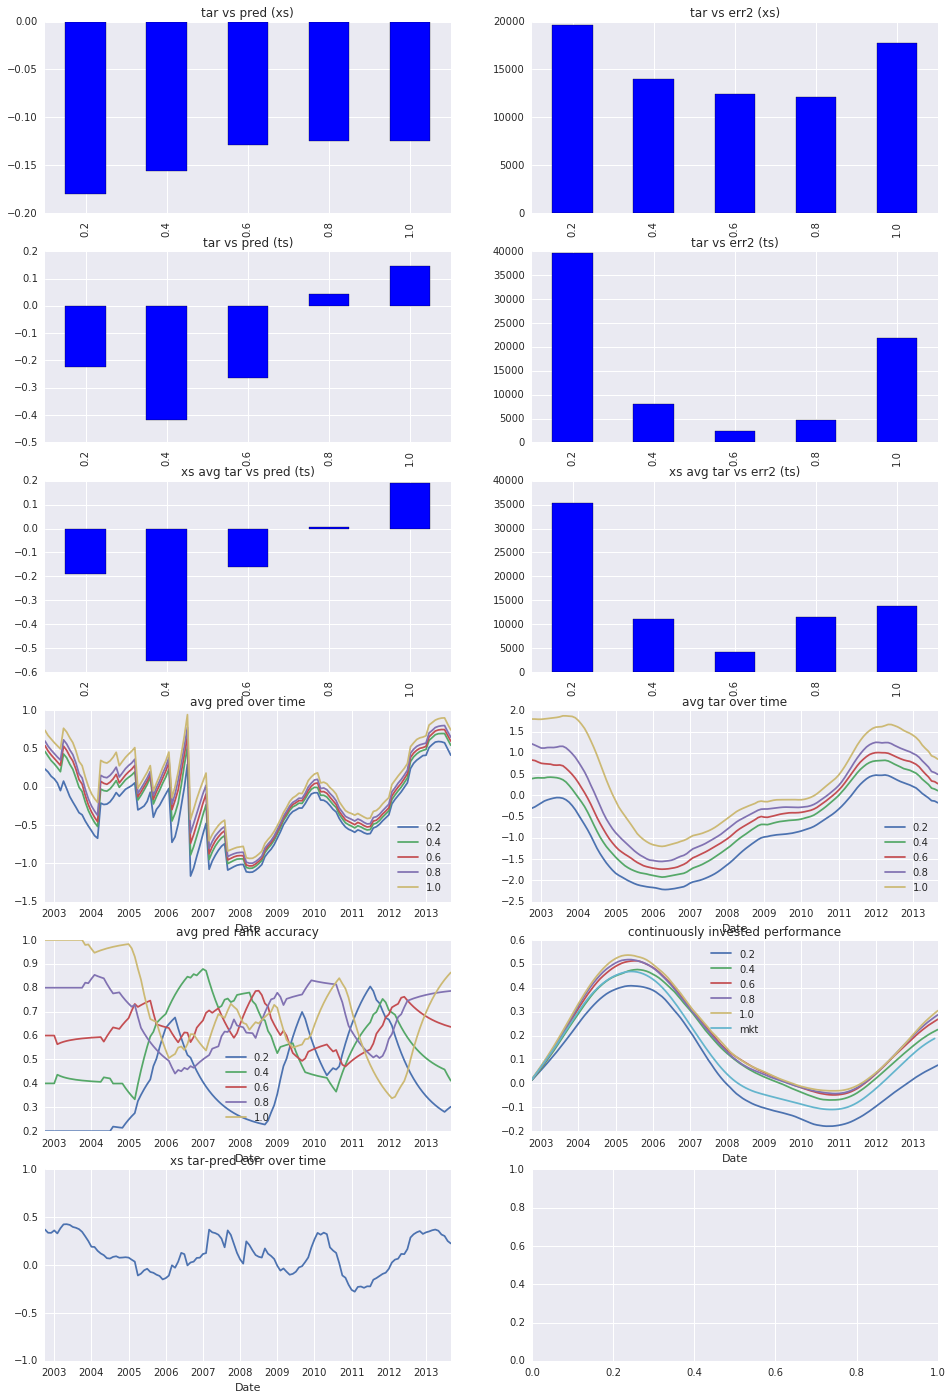

In [115]:
pred = composite.rolling_fit(clf, df_ts)
res = composite.model_empirics(clf, df_ts.ix[pred.index], pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.intercept_, clf.coef_)) 

In [116]:
b_range = res[0].iloc[0].name[0], res[0].iloc[-1].name[0]
b_index = res[0].index

In [117]:
print(a_range)
print(b_range)

(Timestamp('1999-10-31 00:00:00'), Timestamp('2013-09-30 00:00:00'))
(Timestamp('2002-10-31 00:00:00'), Timestamp('2013-09-30 00:00:00'))


ml models



r2: 0.440197	xs corr: 0.268725


sharpe ratios:
0.2    1.052293
0.4    1.660585
0.6    1.961956
0.8    2.195393
1.0    2.283719
mkt    1.837238
dtype: float64


int: -0.000000	coef: [ 0.06834183 -0.03463307  0.14010571 -0.07342094 -0.02297924  0.55686932
  0.08107634 -0.24059927]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


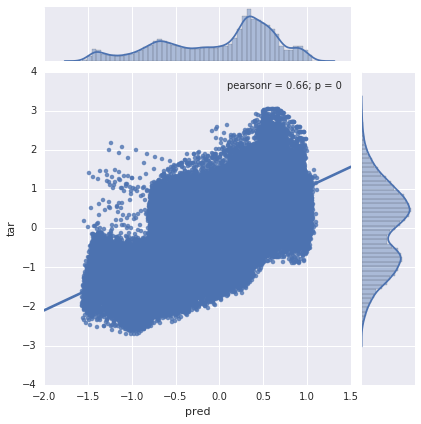

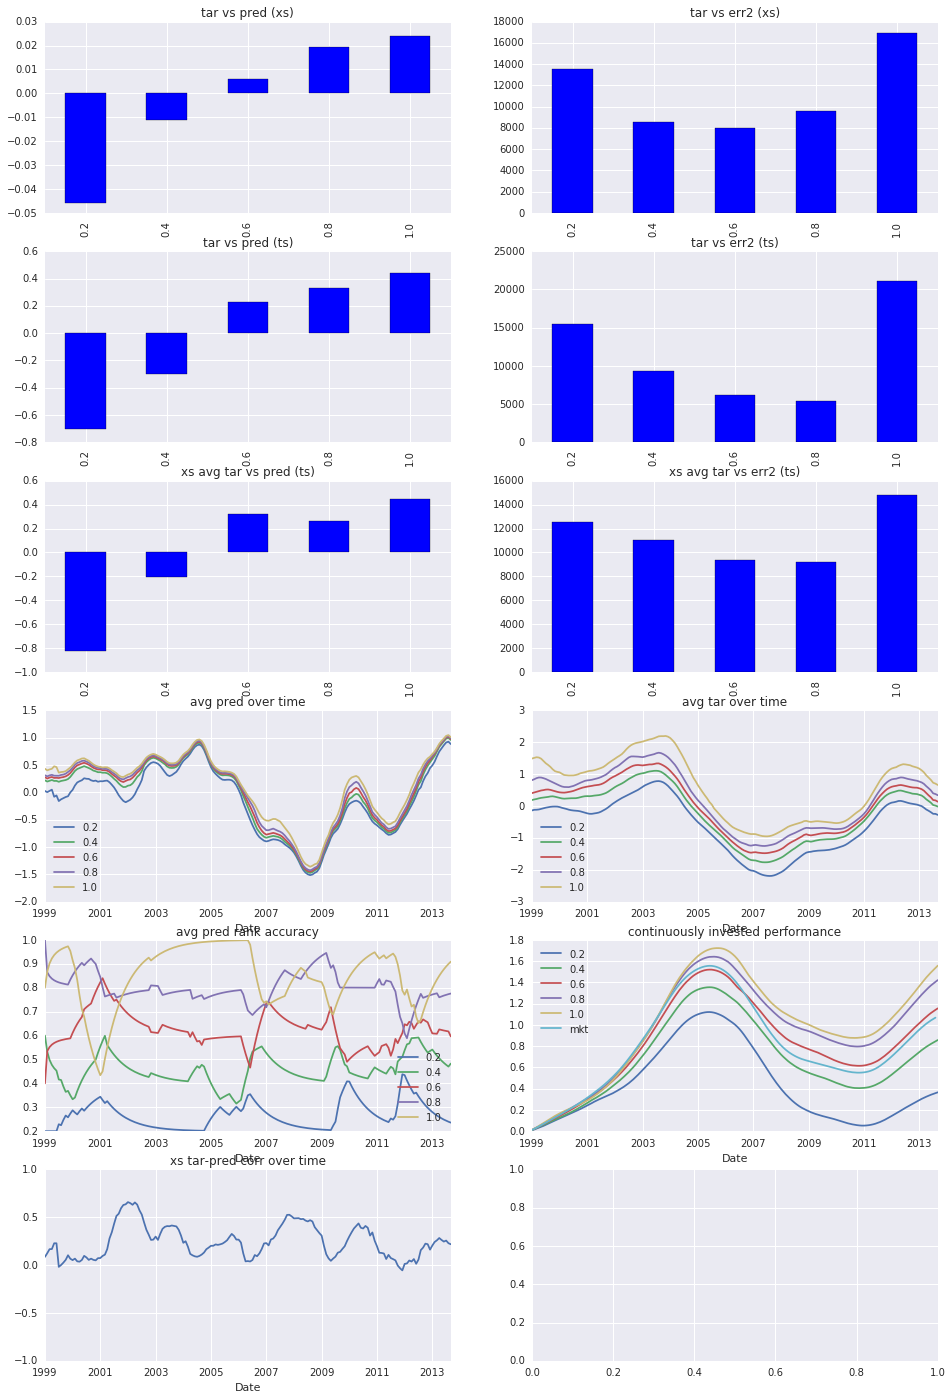

In [61]:
clf = lm.Ridge(alpha=5000)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')
res = composite.model_empirics(clf, df_ts, pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.intercept_, clf.coef_)) 

In [26]:
clf = GridSearchCV(lm.Ridge(), 
                   param_grid={'alpha': [1., 10., 100, 1000, 10000, 50000, 10000000]}, 
                   cv=5, iid=False)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')

# res = composite.model_empirics(clf, df_ts, pred)
# print('\n')
# print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

[mean: -4.43704, std: 1.87222, params: {'alpha': 1.0},
 mean: -4.41876, std: 1.86114, params: {'alpha': 10.0},
 mean: -4.26905, std: 1.77079, params: {'alpha': 100},
 mean: -3.69715, std: 1.41516, params: {'alpha': 1000},
 mean: -2.73244, std: 0.91773, params: {'alpha': 10000},
 mean: -2.24987, std: 0.96047, params: {'alpha': 50000},
 mean: -3.79058, std: 2.68568, params: {'alpha': 10000000}]


Ridge(alpha=50000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)




r2: 0.107805	xs corr: 0.228741


sharpe ratios:
0.2    0.566309
0.4    1.100585
0.6    1.353112
0.8    1.528008
1.0    1.519567
mkt    1.153434
dtype: float64


int: 0.012679	coef: [ 0.09178156 -0.02119535  0.11718011 -0.11177479 -0.01983533  0.23232654
  0.12209329 -0.02341312]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


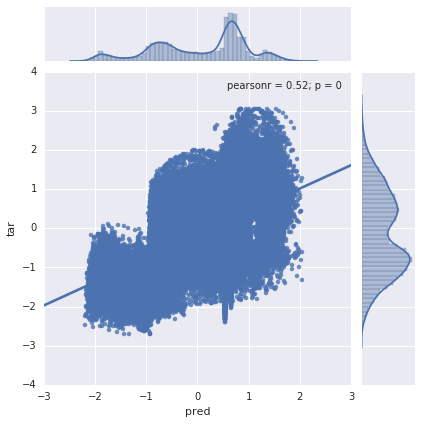

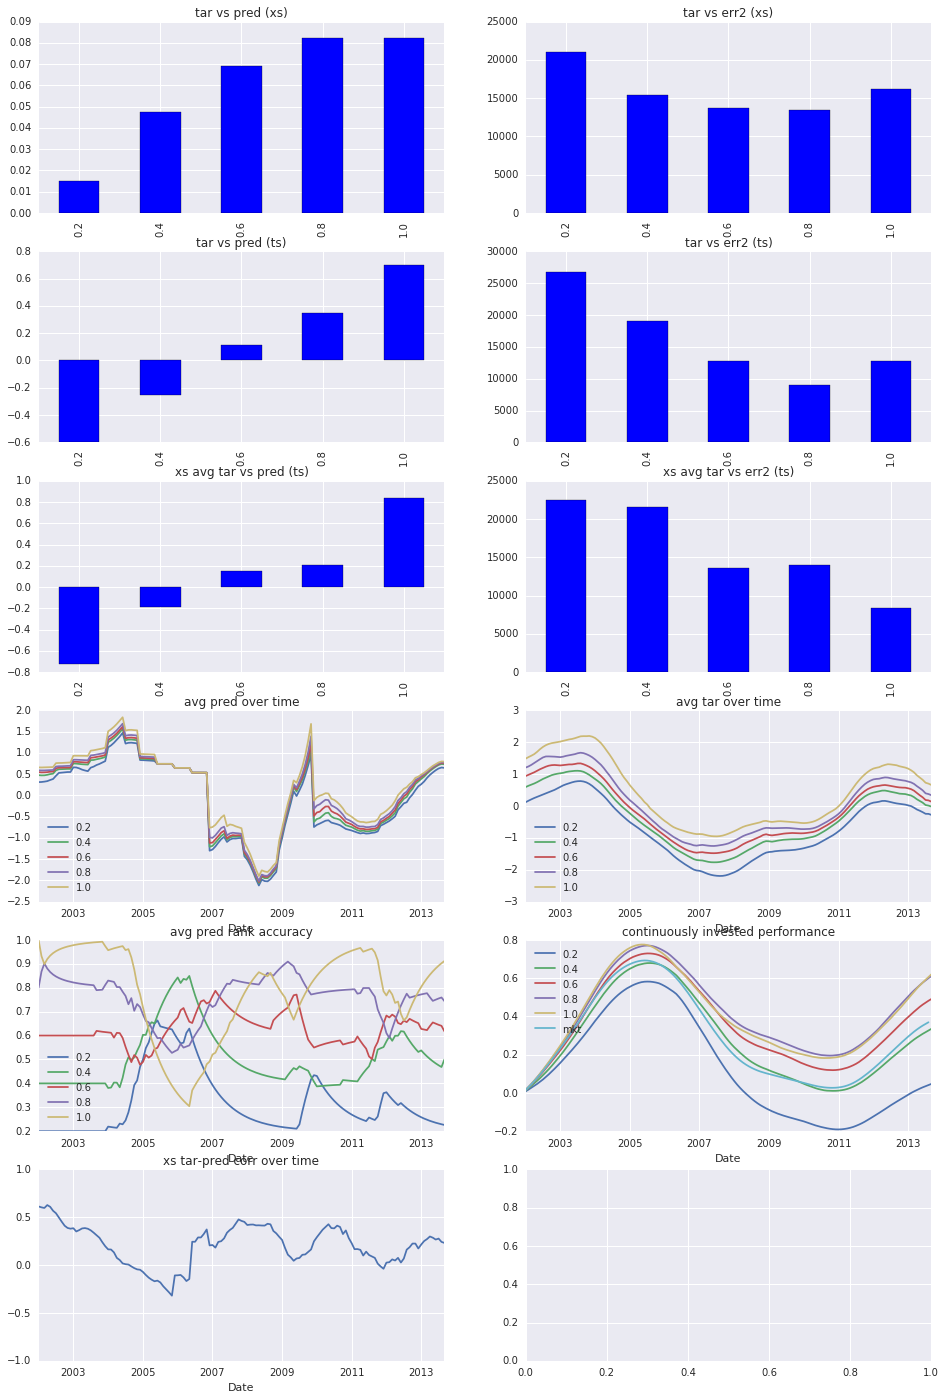

In [53]:
pred = composite.rolling_fit(clf, df_ts)
res = composite.model_empirics(clf, df_ts.ix[pred.index], pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

In [54]:
pred.reset_index().to_csv('data/processed/pred.csv', index=False)

show prediction in map

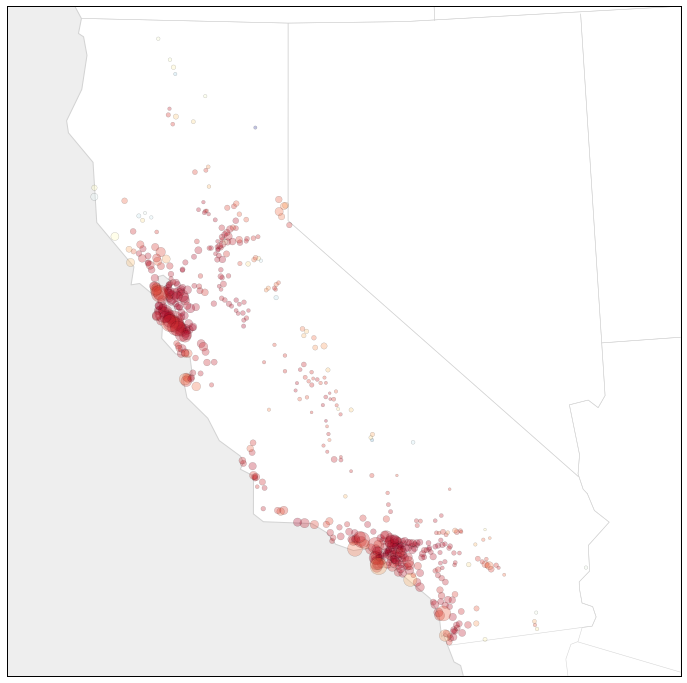

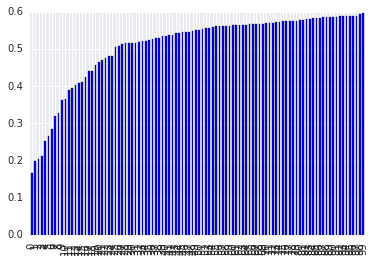

In [38]:
map_pred = maps.load_pred_for_map()
cm = plt.cm.get_cmap('RdYlBu')
m = maps.draw_CA()
row = map_pred.loc[map_pred.index.levels[0][-1]]
style = dict(marker='o', alpha=0.3, zorder=2, latlon=True, label='cities', cmap=cm)
m.scatter(row.lon.values, row.lat.values, s=row.px.map(lambda x: x * .0001).values, c=row.pred.values * -1., **style)
plt.figure()
pd.Series(row.sample(n=100).pred.sort_values().values).plot(kind='bar', figsize=(6,4))

lasso model

/home/condauser/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


[mean: -4.41798, std: 1.85926, params: {'alpha': 0.0001},
 mean: -4.24269, std: 1.73813, params: {'alpha': 0.001},
 mean: -3.42048, std: 1.32805, params: {'alpha': 0.01},
 mean: -2.17337, std: 1.19156, params: {'alpha': 0.1}]


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


r2: 0.400380	xs corr: 0.283549


sharpe ratios:
0.2    1.049194
0.4    1.635928
0.6    1.960771
0.8    2.153254
1.0    2.309174
mkt    1.837238
dtype: float64


int: -0.000000	coef: [ 0.03169041 -0.         -0.          0.01321013 -0.          0.51507561
  0.         -0.        ]


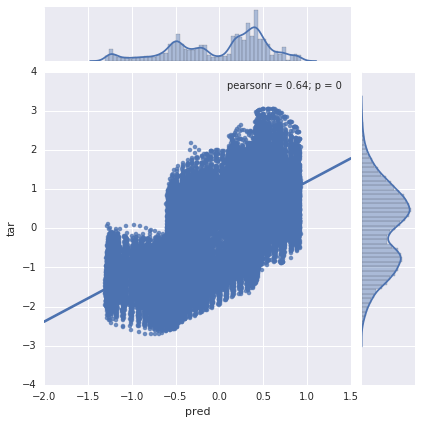

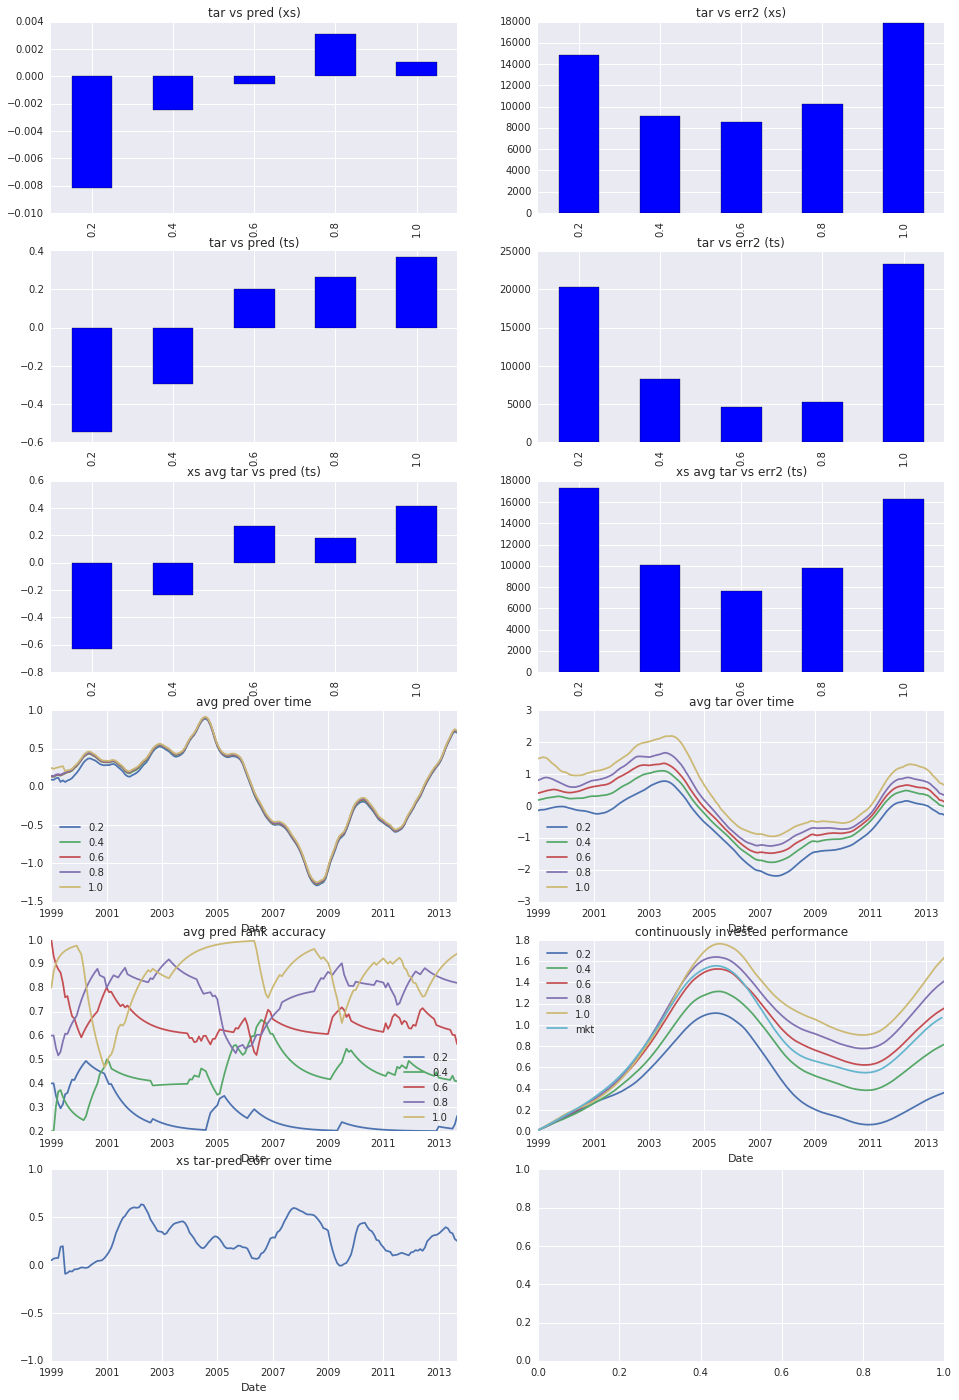

In [39]:
clf = GridSearchCV(lm.Lasso(), 
                   param_grid={'alpha': [.0001, .001, .01, .1]}, 
                   cv=5, iid=False)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')

res = composite.model_empirics(clf, df_ts, pred)
print('\n')
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

[mean: -4.62317, std: 2.16622, params: {'max_depth': 2, 'max_features': None},
 mean: -2.38437, std: 1.19297, params: {'max_depth': 2, 'max_features': 1},
 mean: -2.85563, std: 1.61986, params: {'max_depth': 2, 'max_features': 2},
 mean: -3.81820, std: 1.48431, params: {'max_depth': 5, 'max_features': None},
 mean: -2.63814, std: 1.66583, params: {'max_depth': 5, 'max_features': 1},
 mean: -3.12259, std: 1.74845, params: {'max_depth': 5, 'max_features': 2}]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features=1, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


r2: 0.466449	xs corr: 0.255016


sharpe ratios:
0.2    1.322737
0.4    1.512395
0.6    1.785071
0.8    1.994691
1.0    1.382047
mkt    1.837238
dtype: float64




/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


AttributeError: 'RandomForestRegressor' object has no attribute 'intercept_'

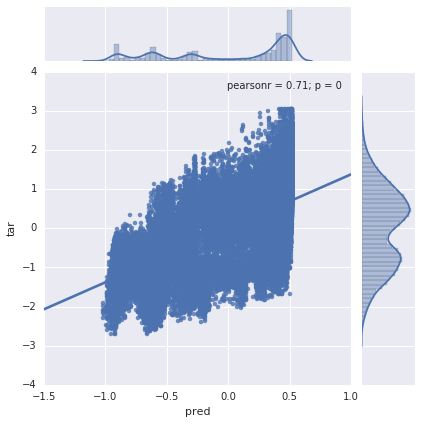

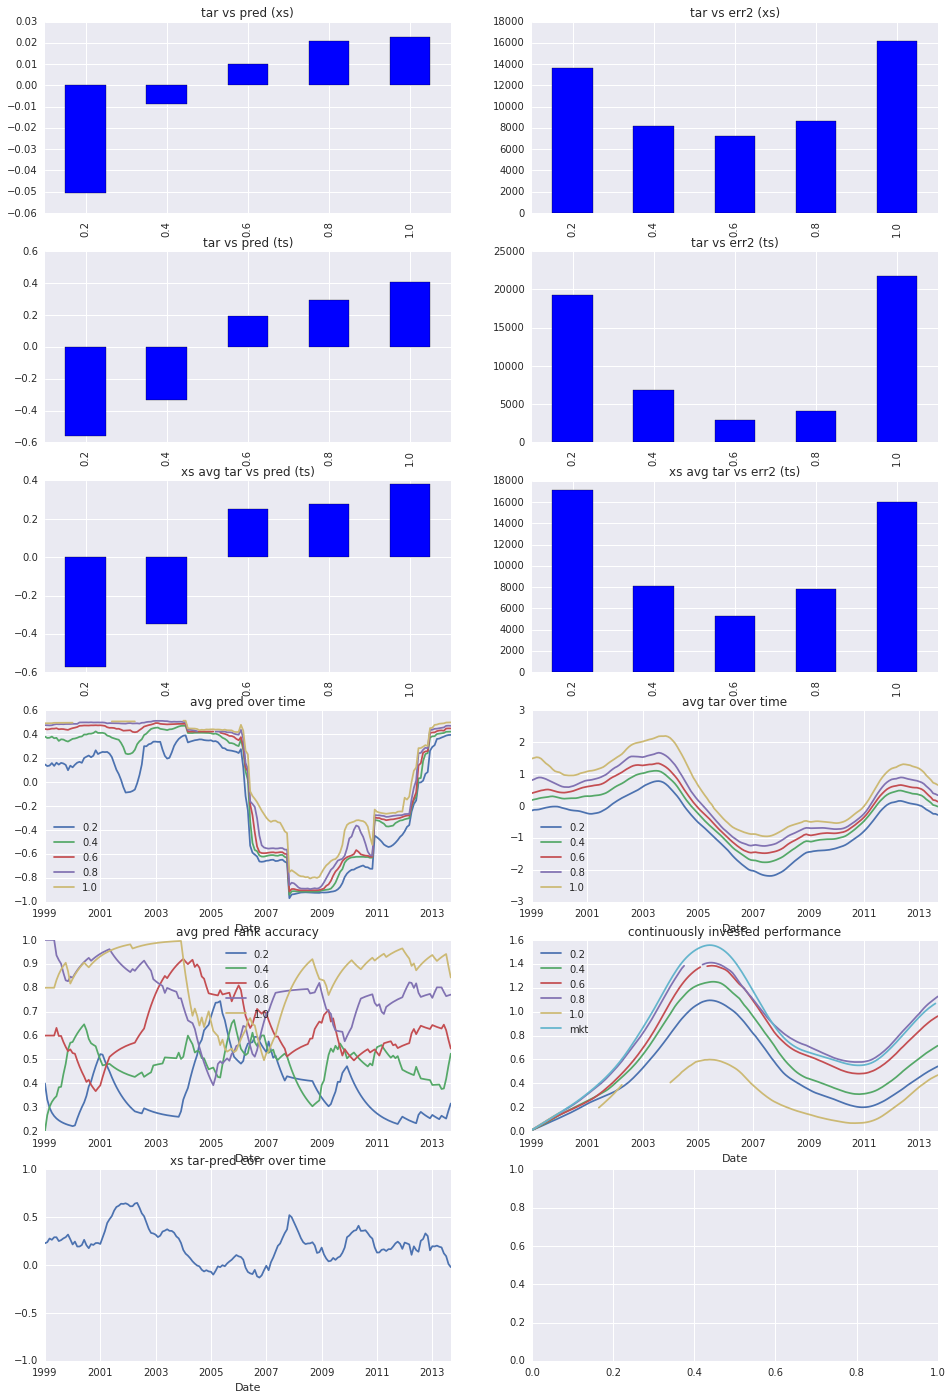

In [40]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=50), 
                   param_grid={'max_depth': [2,5,], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf.fit(df_ts[[c for c in df_ts.columns if c != 'tar']], df_ts['tar'])
pprint(clf.grid_scores_)
print('\n')
pprint(clf.best_estimator_)

pred = pd.Series(clf.predict(df_ts[[c for c in df_ts.columns if c != 'tar']]), 
                 index=df_ts.index, name='pred')

res = composite.model_empirics(clf, df_ts, pred)

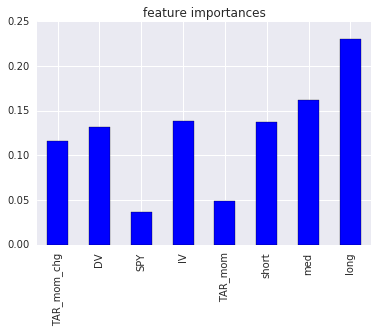

In [41]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

In [238]:

p = rolling_fit(clf.best_estimator_, df)

2002-01-15 00:00:00
2002-07-14 00:00:00
2003-01-10 00:00:00
2003-07-09 00:00:00
2004-01-05 00:00:00
2004-07-03 00:00:00
2004-12-30 00:00:00
2005-06-28 00:00:00
2005-12-25 00:00:00
2006-06-23 00:00:00
2006-12-20 00:00:00
2007-06-18 00:00:00
2007-12-15 00:00:00
2008-06-12 00:00:00
2008-12-09 00:00:00
2009-06-07 00:00:00
2009-12-04 00:00:00
2010-06-02 00:00:00
2010-11-29 00:00:00
2011-05-28 00:00:00
2011-11-24 00:00:00
2012-05-22 00:00:00
2012-11-18 00:00:00
2013-05-17 00:00:00


In [ ]:
1 + 1

In [239]:
p.shape

Date        code 
2002-01-31  00002    0.580614
            00007    0.471052
            00008    0.308400
            00010    0.294604
            00026    0.580614
            00028    0.580614
            00029    0.471052
            00037    0.384510
            00040    0.580614
            00042    0.580614
            00044    0.471052
            00047    0.580614
            00053    0.471052
            00056    0.471052
            00068    0.580614
            00069    0.580614
            00080    0.580614
            00087    0.472697
            00088    0.294604
            00089    0.580614
            00098    0.580614
            00101    0.567884
            00107    0.580614
            00108    0.580614
            00109    0.580614
            00114    0.579449
            00116    0.580614
            00122    0.580614
            00126    0.580614
            00127    0.580614
                       ...   
2013-09-30  08141    0.347195
            08194    0

Timestamp('1999-01-31 00:00:00')

In [ ]:
# clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
#                                                             'max_depth': [1,3,5], 
#                                                             'max_features': [None, 1, 2]}, 
#                    cv=5, n_jobs=2, idd=False)
# clf, df_res, score, pred = composite.build_model(clf, df)

In [ ]:
# (pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
#  .plot(kind='bar', title='feature importances'))

build model with xs ranked features and targets

In [210]:
def xs_rank_features(df, skip=('long', 'med', 'short')):
    for c in df.columns:
        if c not in skip:
            df[c] = ut.get_row_percentile(df[c])
    return df
df_r = xs_rank_features(df)

[mean: 0.05644, std: 0.05025, params: {'max_depth': 2, 'max_features': None},
 mean: 0.04220, std: 0.02715, params: {'max_depth': 2, 'max_features': 1},
 mean: 0.05628, std: 0.03230, params: {'max_depth': 2, 'max_features': 2},
 mean: 0.04307, std: 0.05700, params: {'max_depth': 3, 'max_features': None},
 mean: 0.04769, std: 0.03265, params: {'max_depth': 3, 'max_features': 1},
 mean: 0.05434, std: 0.04096, params: {'max_depth': 3, 'max_features': 2},
 mean: 0.02229, std: 0.07240, params: {'max_depth': 5, 'max_features': None},
 mean: 0.04896, std: 0.04896, params: {'max_depth': 5, 'max_features': 1},
 mean: 0.04359, std: 0.05488, params: {'max_depth': 5, 'max_features': 2},
 mean: 0.00546, std: 0.09300, params: {'max_depth': 7, 'max_features': None},
 mean: 0.04467, std: 0.05805, params: {'max_depth': 7, 'max_features': 1},
 mean: 0.02976, std: 0.06740, params: {'max_depth': 7, 'max_features': 2}]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_fea

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


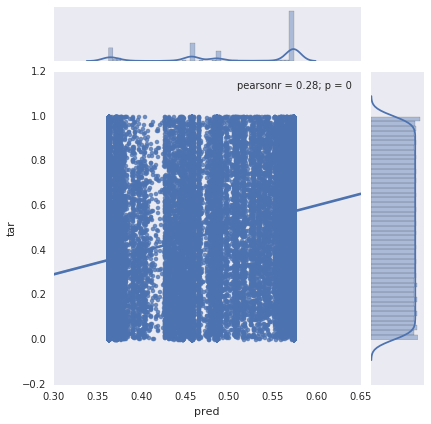

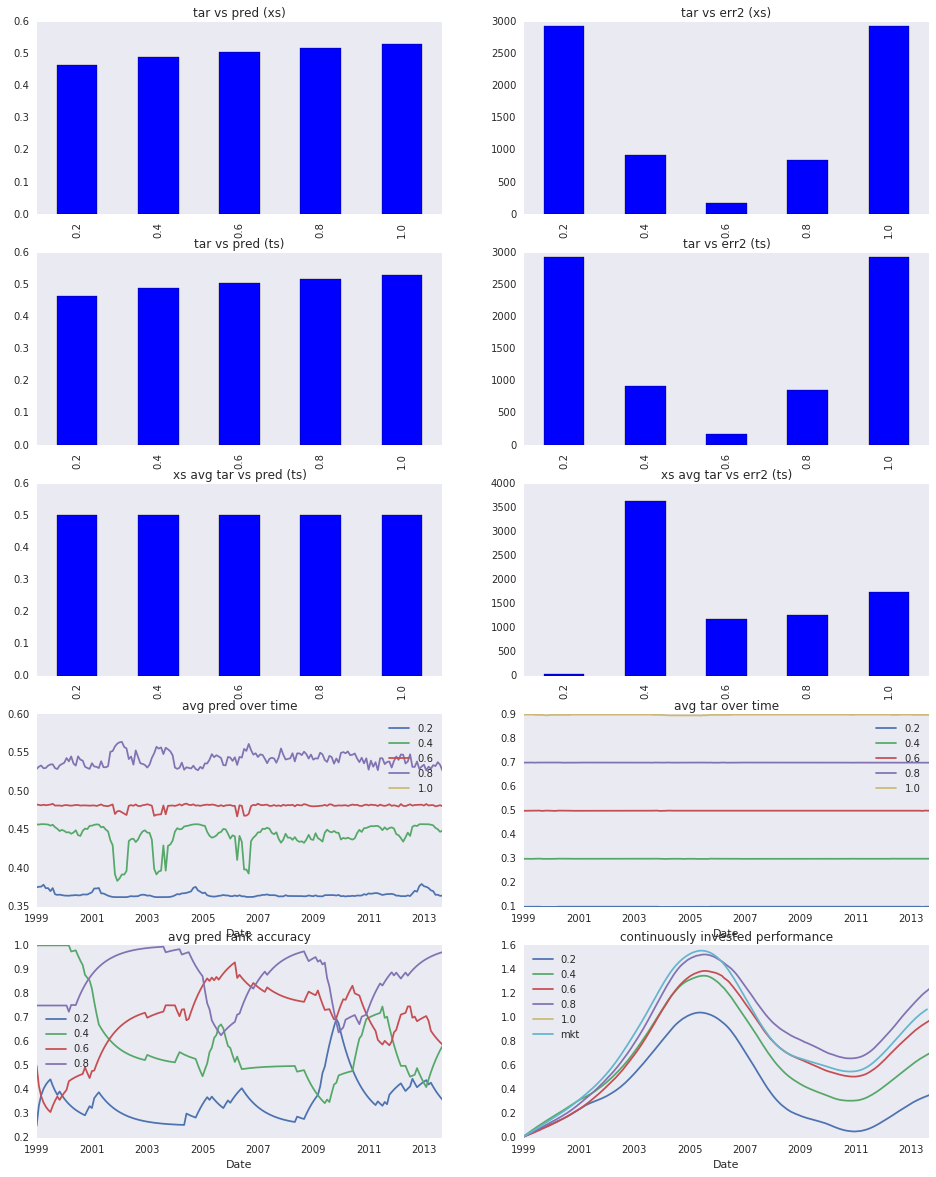

In [212]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100, oob_score=True), 
                   param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf, res, score, pred = composite.build_model(clf, df_r)

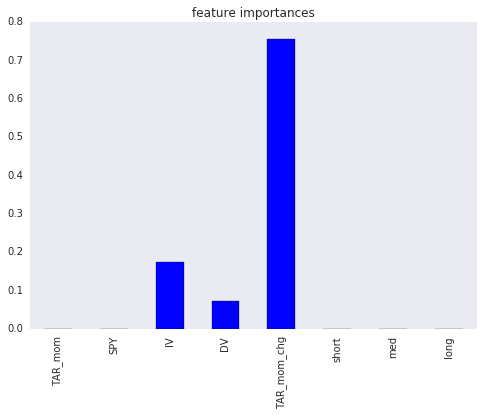

In [218]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

build rolling fit model